#### 问题1：假定各种农作物未来的预期销售量、种植成本、亩产量和销售价格相对于 2023 年保持稳定，每季种植的农作物在当季销售。如果某种作物每季的总产量超过相应的预期销售量，超过部分不能正常销售。请针对以下两种情况，分别给出该乡村 2024~2030 年农作物的最优种植方案，将结果分别填入 result1_1.xlsx 和 result1_2.xlsx 中（模板文件见附件 3）。
* (1) 超过部分滞销，造成浪费；
* (2) 超过部分按 2023 年销售价格的 50%降价出售。

注：	
* (1) 水浇地的第一季通常是在每年的3月至6月前后，第二季是在7月至10月前后。		
* (2) 普通大棚的第一季通常是在每年的5月至9月前后，第二季是在9月至下一年4月前后。		
* (3) 智慧大棚的第一季通常是在每年的3月至7月前后，第二季是在8月至下一年的2月前后。		
注：
* (1) 该数据是2023年根据近几年的相应数据统计所得。								
* (2) 智慧大棚第一季可种植的蔬菜作物及其亩产量、种植成本和销售价格均与普通大棚相同，表中省略。								


#### 假设农民是理性的有预期的种植，产出的产量总是和市场需求大致相同。

#### 思路：一共六种地块类型，34个地块，平旱地、梯田和山坡种粮食（一季），水浇地种水稻（一季）或蔬菜（两季），普通大棚种蔬菜和食用菌（各一季），智慧大棚种蔬菜（两季）。
* 不能连续种植，也就是说除了水浇地种蔬菜、普通大棚和智慧大棚外，其他的地块都不能在来年种同样类型的植物。
* 如果水浇地种植蔬菜，第一季只能种大白菜、白萝卜和红萝卜除外的蔬菜（可以合种），第二季只能种大白菜、白萝卜和红萝卜（不可合种）。
* 智慧大棚不能种大白菜、白萝卜和红萝卜。
* 每三年所有土壤都必须种一次豆类，如果2023年的数据该地块每种，则接下来的两年就必须种，如果种植，那么这个时间需要重新计算。
* 作物种植不能太分散
* 每个作物在单个地块种植面积不能太小。
* 需要考虑下滞销问题（但这个属于附加项，直观一点来说，我们简单的将2023年的数据作为未来的销量，然后直接就将这个附加项给处理掉。但另外的，也可以考虑更加复杂的情况，将可能滞销的销量作为一个优化问题的随机扰动项）
##### 现在的问题是：给定销量、成本、产量和销售价格，给出最优种植方案。本质上这是一个优化模型，需要考虑的是，何为最优种植方案。一般来说，这种优化模型就是利润最大化模型，但基于利润最大化优化模型，还可以提出改进模型，比如基于效率的利润最大化优化模型。将效率考虑到优化模型中。

### 数据处理，把附件1、2的不同sheet里的内容融合到一起
#### 需要注意的是，我们只融合那些2023年存在记录（销量）的数据

In [1]:
## 导入会使用到的库
%config InlineBackend.figure_format = 'retina'
%matplotlib inline    
import seaborn as sns 
sns.set(font= "simhei",style="whitegrid",font_scale=1.6)
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False # 解决坐标轴的负号显示问题
## 导入需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px

## 忽略提醒
import warnings
warnings.filterwarnings("ignore")

In [2]:
df1 = pd.read_excel('数据\\附件1.xlsx',sheet_name=0)
df2 = pd.read_excel('数据\\附件1.xlsx',sheet_name=1)
df3 = pd.read_excel('数据\\附件2.xlsx',sheet_name=0)
df4 = pd.read_excel('数据\\附件2.xlsx',sheet_name=1)

#对附件1的sheet2做处理
ls = []
for name,typ,soils in zip(df2.作物名称,df2.作物类型,df2.种植耕地):
    for soil in soils.split('\n\n'):
        ls.append([name,typ,soil])
d = pd.DataFrame(ls,columns=['作物名称','作物类型','种植耕地'])

ls1 = []
ls2 = []
for i in d.种植耕地:
    if '季' in i:
        ls1.append(i.split(' ')[0])
        ls2.append(i.split(' ')[-1].replace('\n',''))
    else:
        ls1.append(i.replace('\n',''))
        ls2.append('单季')
d['种植耕地'] = ls1

#将字段进行差分
ls1 = []
ls2 = []
for i in d.作物类型:
    if '豆类' in i:
        ls1.append(i.split('（')[0])
        ls2.append('是')
    else:
        ls1.append(i)
        ls2.append('不是')
d['作物类型'] = ls1
d['是否豆类'] = ls2
df2 = d

#同样的逻辑，将附件2的sheet1处理
df3.columns = ['地块名称', '作物编号', '作物名称', '作物类型', '种植面积/亩', '种植季次']
df3 = pd.merge(df1,df3,how='right',on='地块名称')

df3 = pd.DataFrame(df3.groupby(['地块类型','作物编号']).sum()[['种植面积/亩']])
ls1 = []
ls2 = []
for i,o in df3.index:
    ls1.append(i)
    ls2.append(o)
df3['地块类型'] = ls1
df3['作物编号'] = ls2
df3.reset_index(drop=True,inplace=True)

#数据合并
df4 = pd.merge(df4,df3,how='left',on=['地块类型','作物编号']).fillna(0)
df4['地块类型'] = [i.replace(' ','') for i in df4.地块类型]

df2.columns = ['作物名称', '作物类型', '地块类型', '是否豆类']

result = pd.merge(df4,df2,how='left',on=['作物名称', '地块类型'])
result.to_excel('处理后数据.xlsx',index=False)

#### 对于销售单价，我们取平均销售单价作为作物的销售单价

#### 假设农民是理性的有预期的种植，产出的产量总是和市场需求大致相同。

In [3]:
ls = []
for i in result['销售单价/(元/斤)']:
    n = float(i.split('-')[0])
    m = float(i.split('-')[1])
    ls.append((n+m)/2)
result['平均销售单价'] = ls

result['总销量'] = result['亩产量/斤']*result['种植面积/亩']
result['总成本'] = result['平均销售单价']*result['种植面积/亩']
result['总盈利'] = result['总销量']*result['平均销售单价']-result['总成本']

df = result.copy()

#### 不同作物的产量情况，根据假设，销量就等于产量

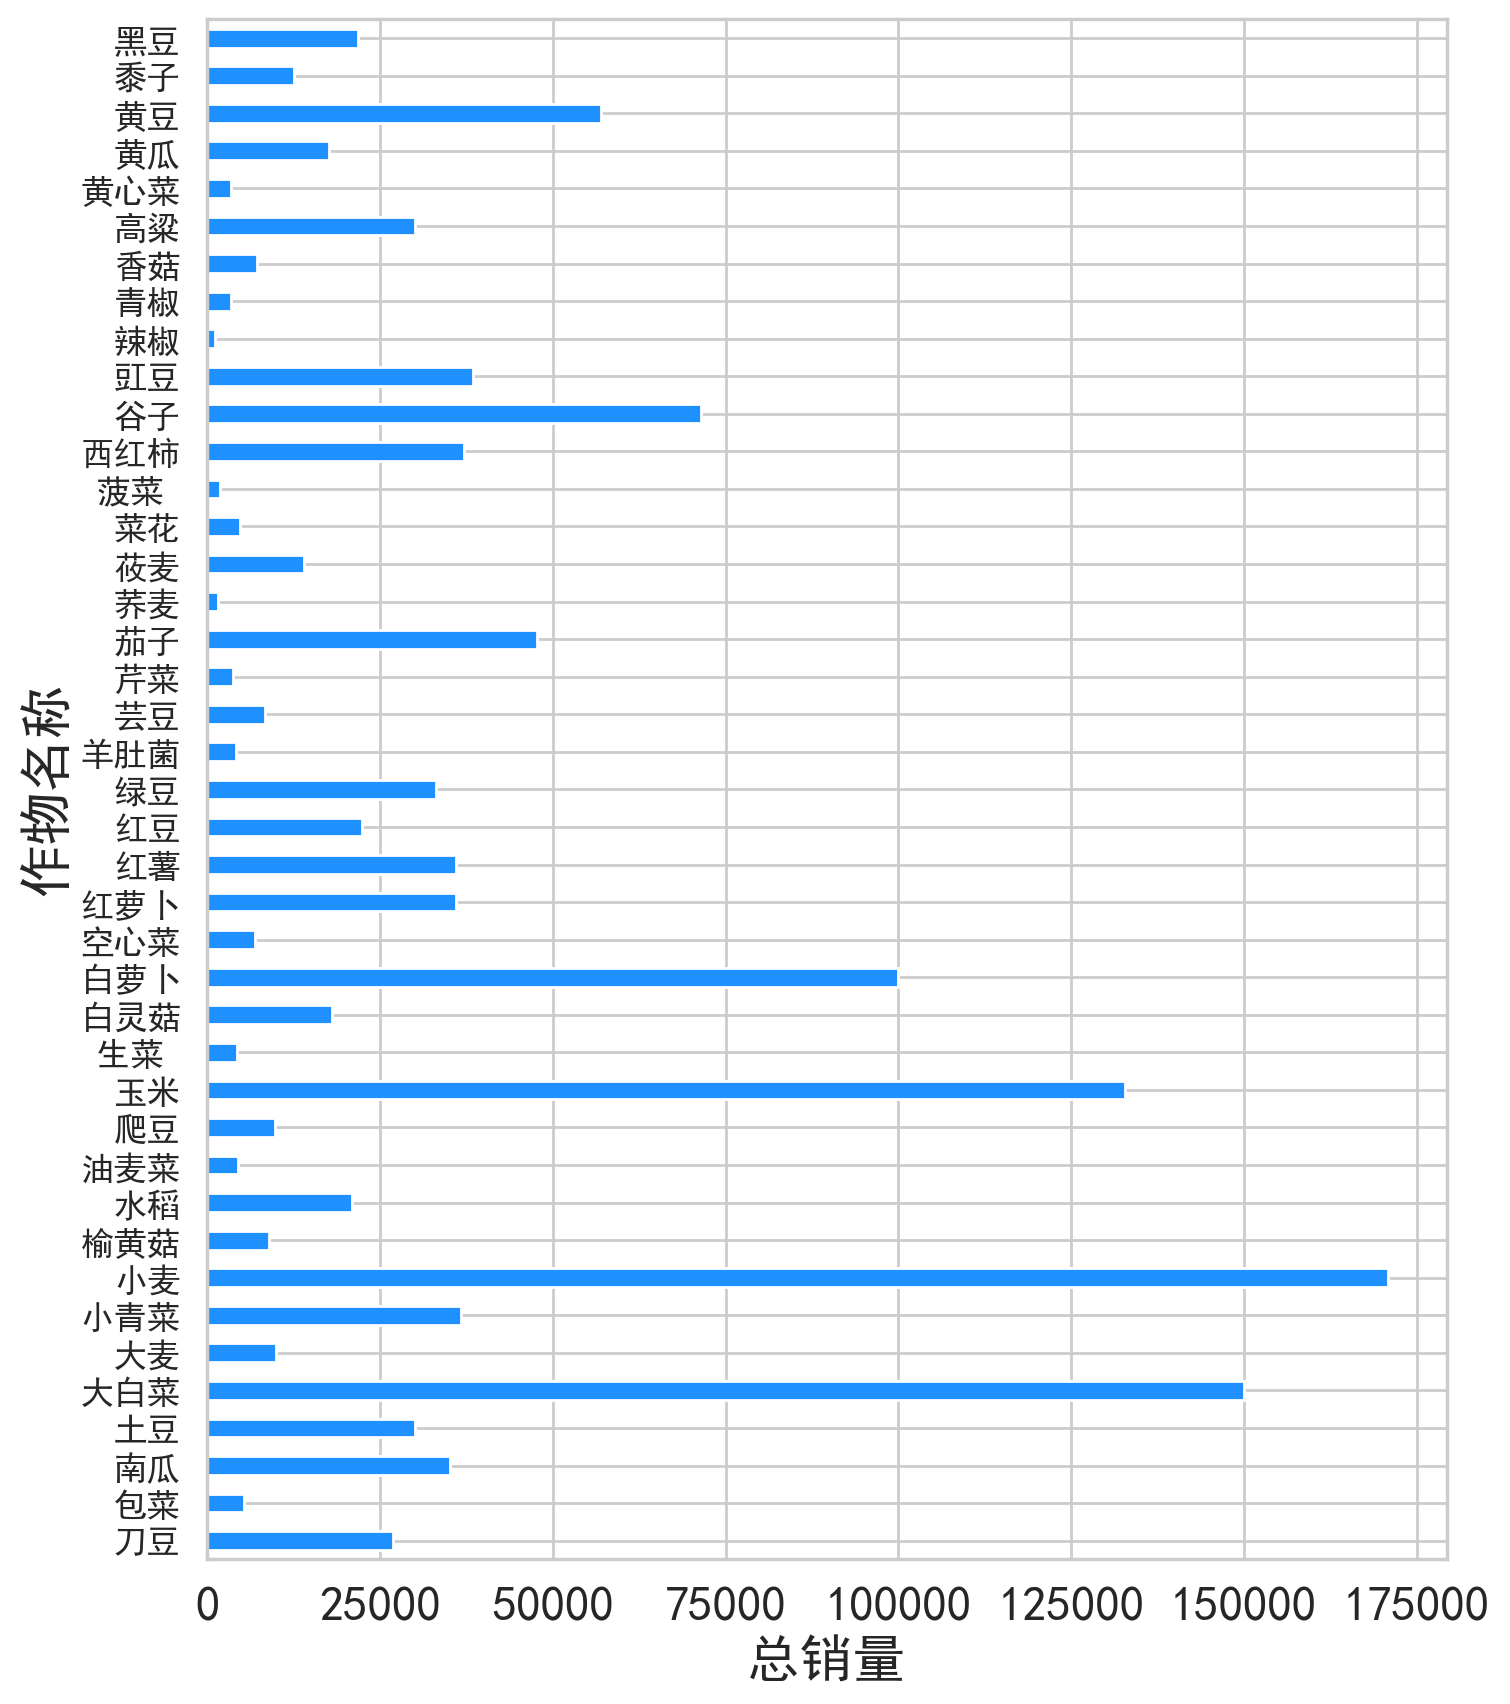

In [4]:
df.groupby('作物名称').sum()['总销量'].plot(kind = "barh",figsize = (8,10), color='#1E90FF') #颜色,matplotlib
plt.xticks(rotation=0)
plt.xlabel("总销量")
plt.ylabel("作物名称")
plt.yticks(fontsize = 12)


plt.show()

#### 不同作物的盈利情况

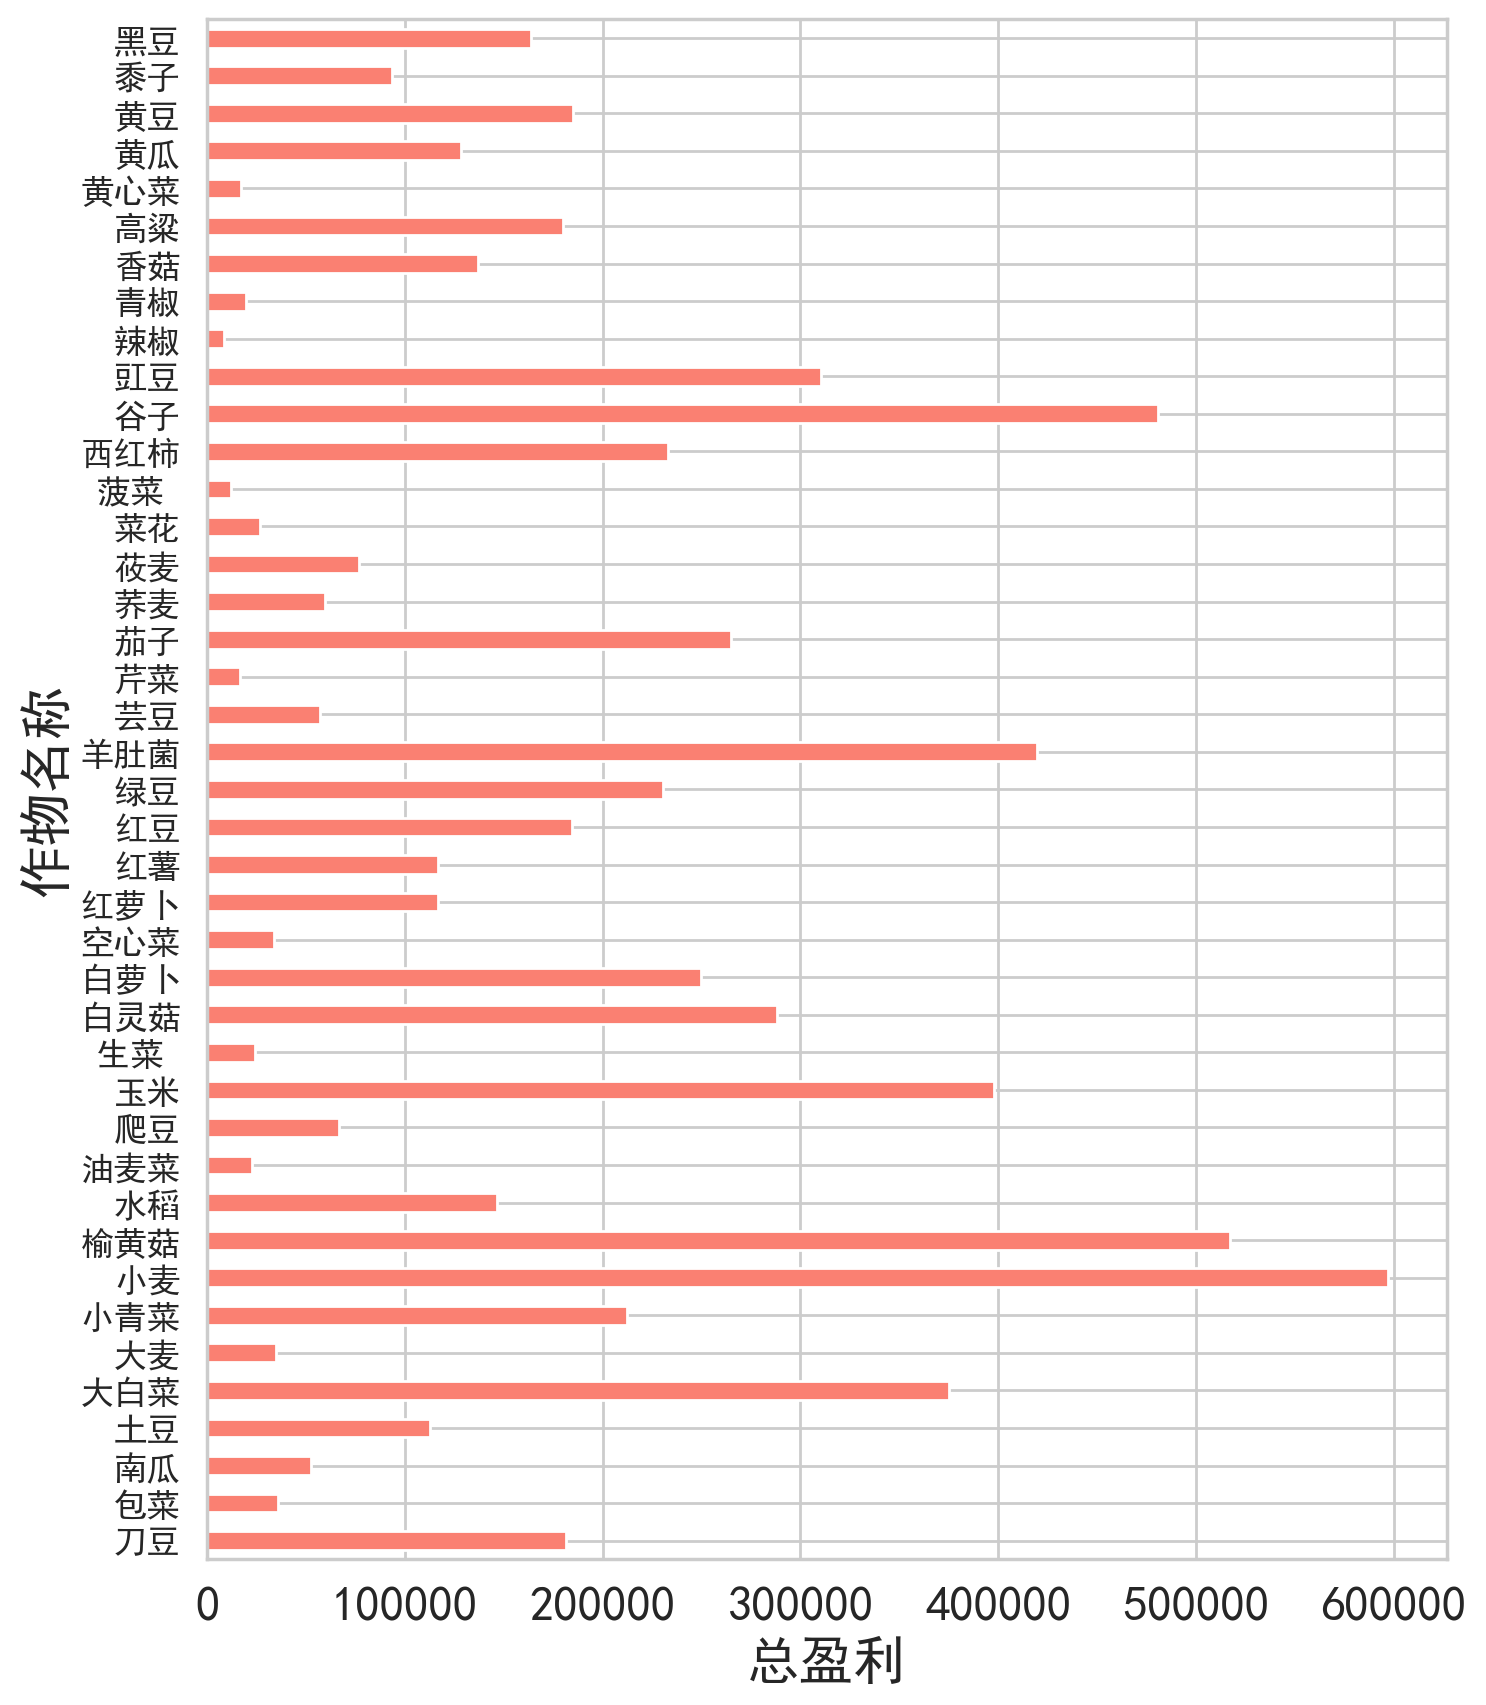

In [5]:
#不同蔬菜品类的数量分布
df.groupby('作物名称').sum()['总盈利'].plot(kind = "barh",figsize = (8,10),color='#FA8072') #颜色,matplotlib
plt.xticks(rotation=0)
plt.xlabel("总盈利")
plt.ylabel("作物名称")
plt.yticks(fontsize = 12)

plt.show()

#### 种植面积和亩产量之间的关系，可以看到，大部分的作物不存在这种关系，而非豆类的数据，存在一部分是正向关系，这可能和规模化有关

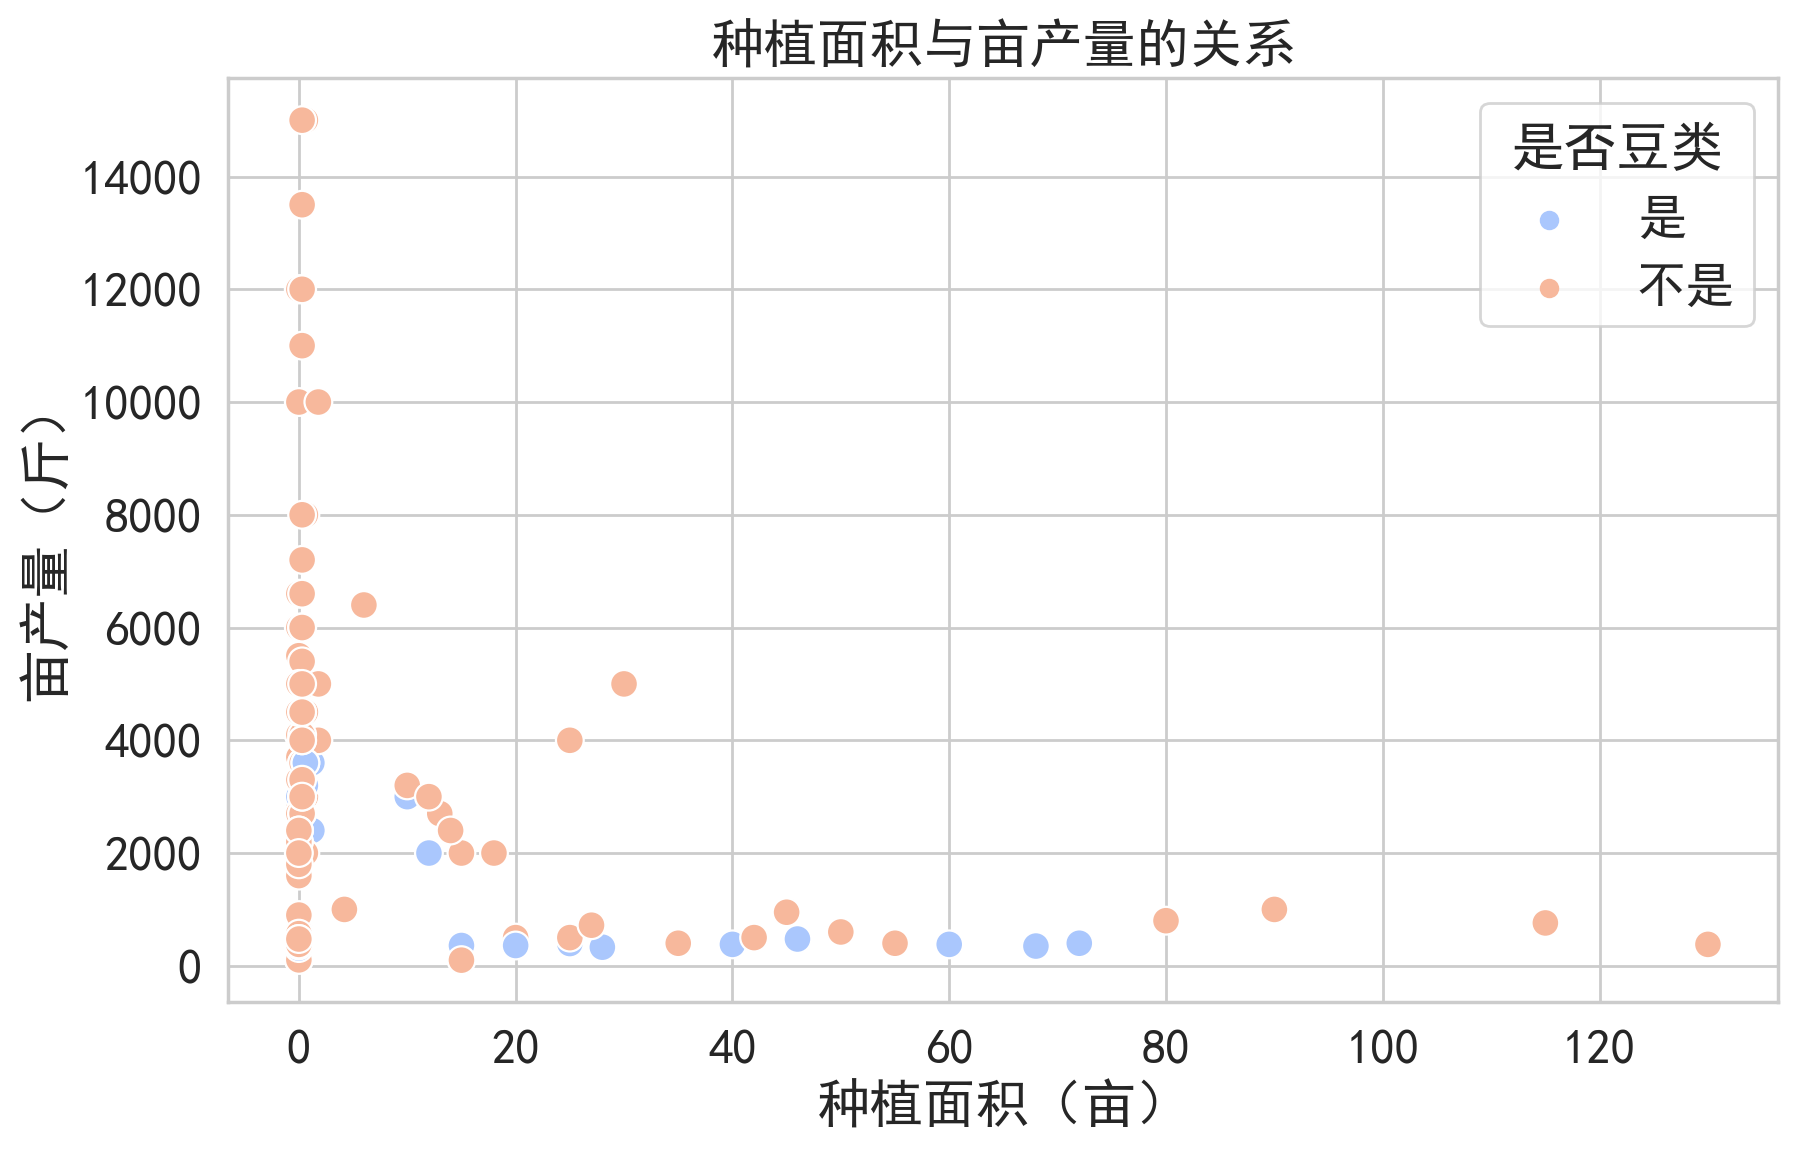

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='种植面积/亩', y='亩产量/斤', hue='是否豆类', palette='coolwarm', s=100)
plt.title('种植面积与亩产量的关系')
plt.xlabel('种植面积（亩）')
plt.ylabel('亩产量（斤）')
plt.legend(title='是否豆类')

plt.show()

#### 不同作物类型的单价分布，可以看到，食用菌的销售价格是最高的，然后粮食的价格也会高于蔬菜

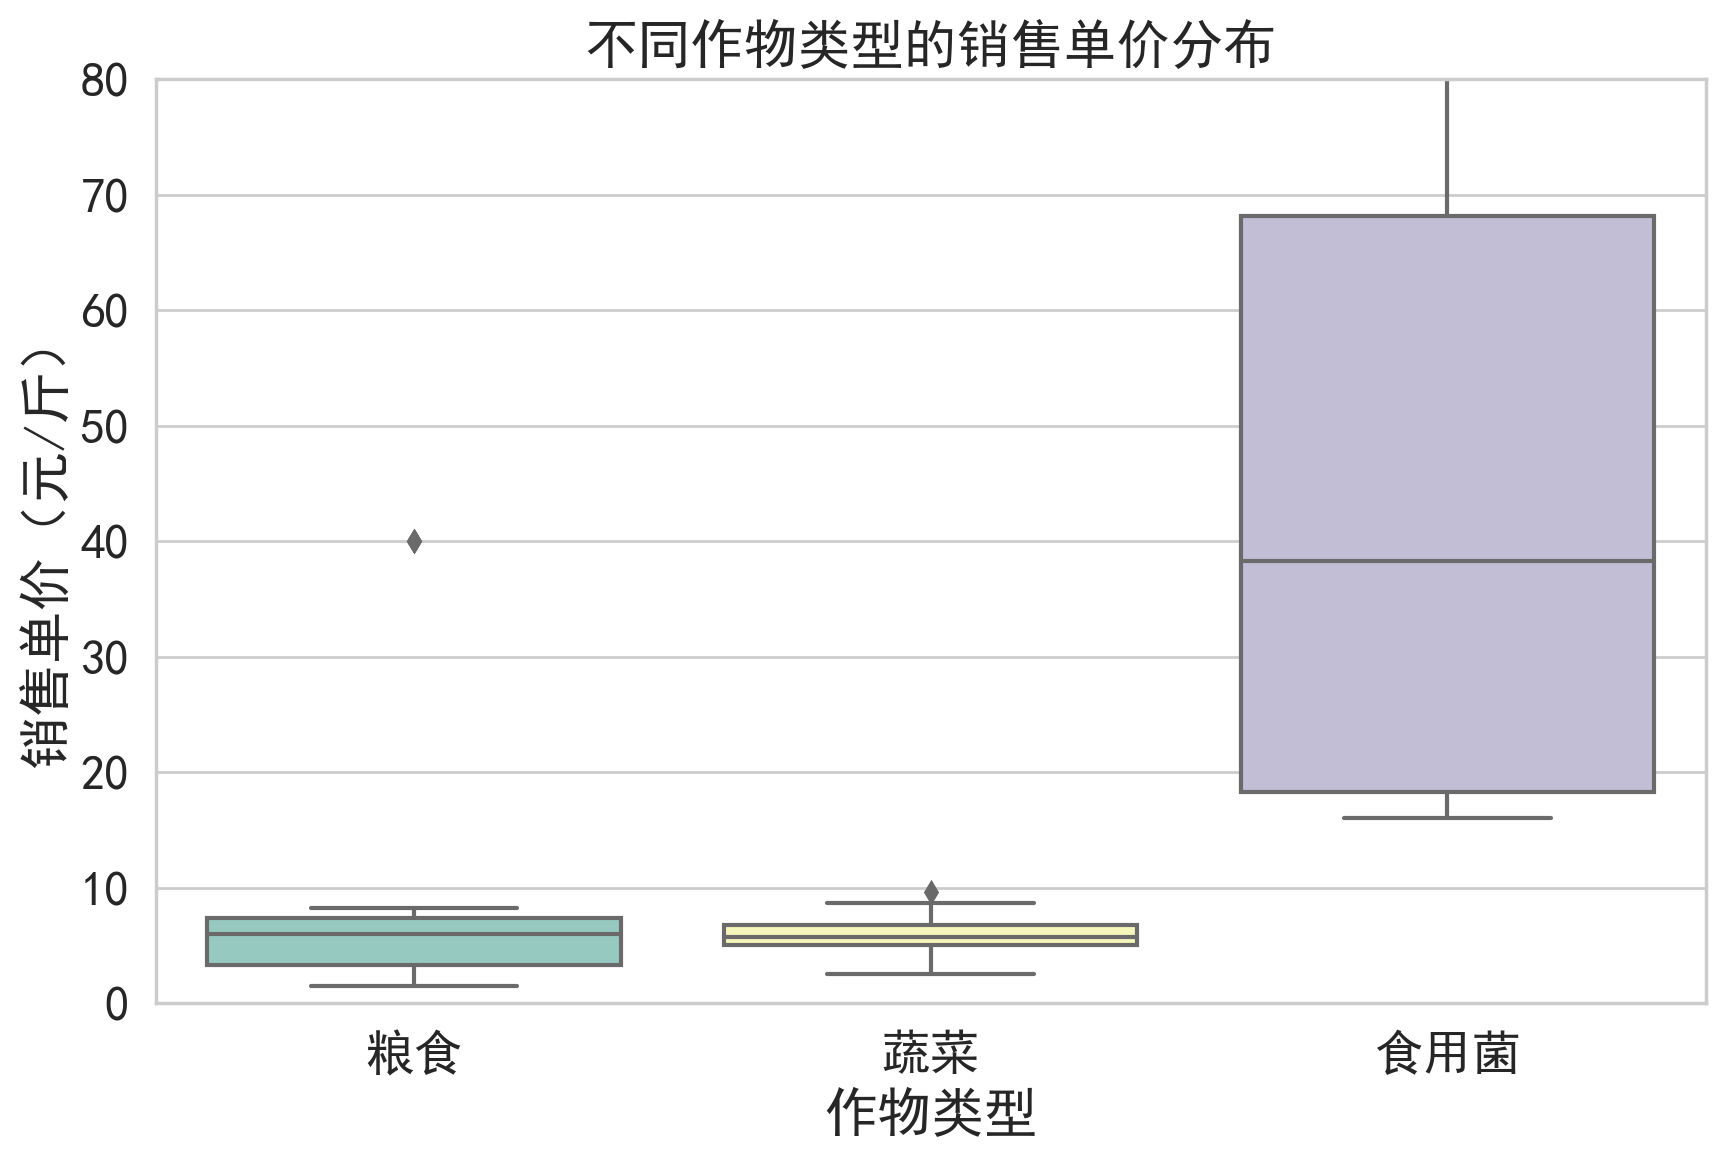

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='作物类型', y='平均销售单价', palette='Set3')
plt.title('不同作物类型的销售单价分布')
plt.xlabel('作物类型')
plt.ylabel('销售单价（元/斤）')
plt.ylim(0,80)

plt.show()


#### 不同季次作物的种植面积,这也和前面的设定相同，平旱地、梯田和山坡只有単季节的粮食，大棚才能种食用菌

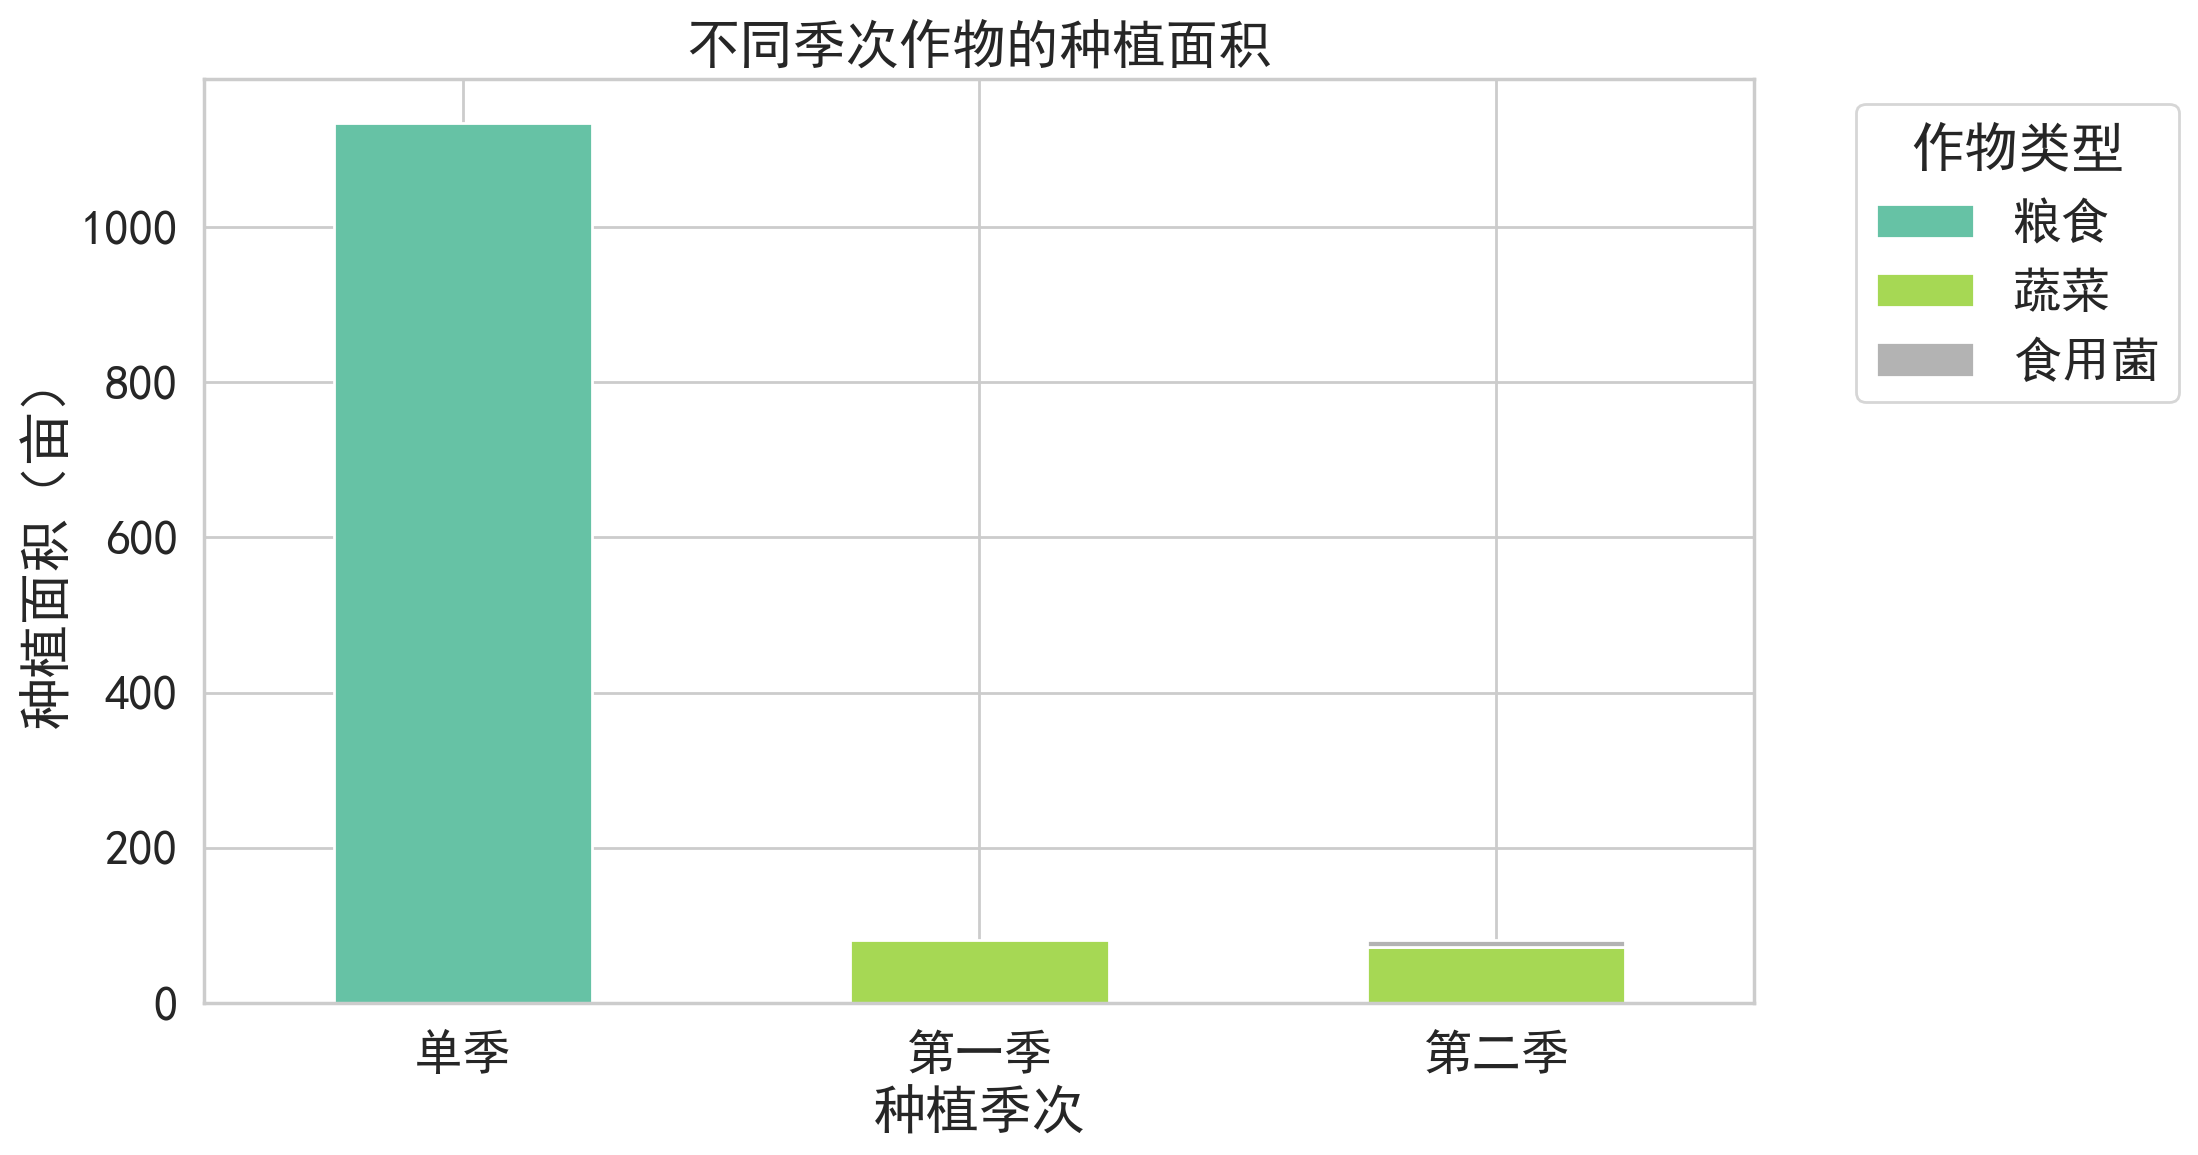

In [8]:
grouped_data = df.groupby(['种植季次', '作物类型'])['种植面积/亩'].sum().unstack()
grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title('不同季次作物的种植面积')
plt.xlabel('种植季次')
plt.ylabel('种植面积（亩）')
plt.legend(title='作物类型', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

plt.show()


#### 为了更清晰的看到种植成本和利润的对比，我们将两个图画在了一起，可以看到只有高盈利的作物，农民才会对其进行加量生成，符合标准的市场规律。

<Figure size 1000x600 with 0 Axes>

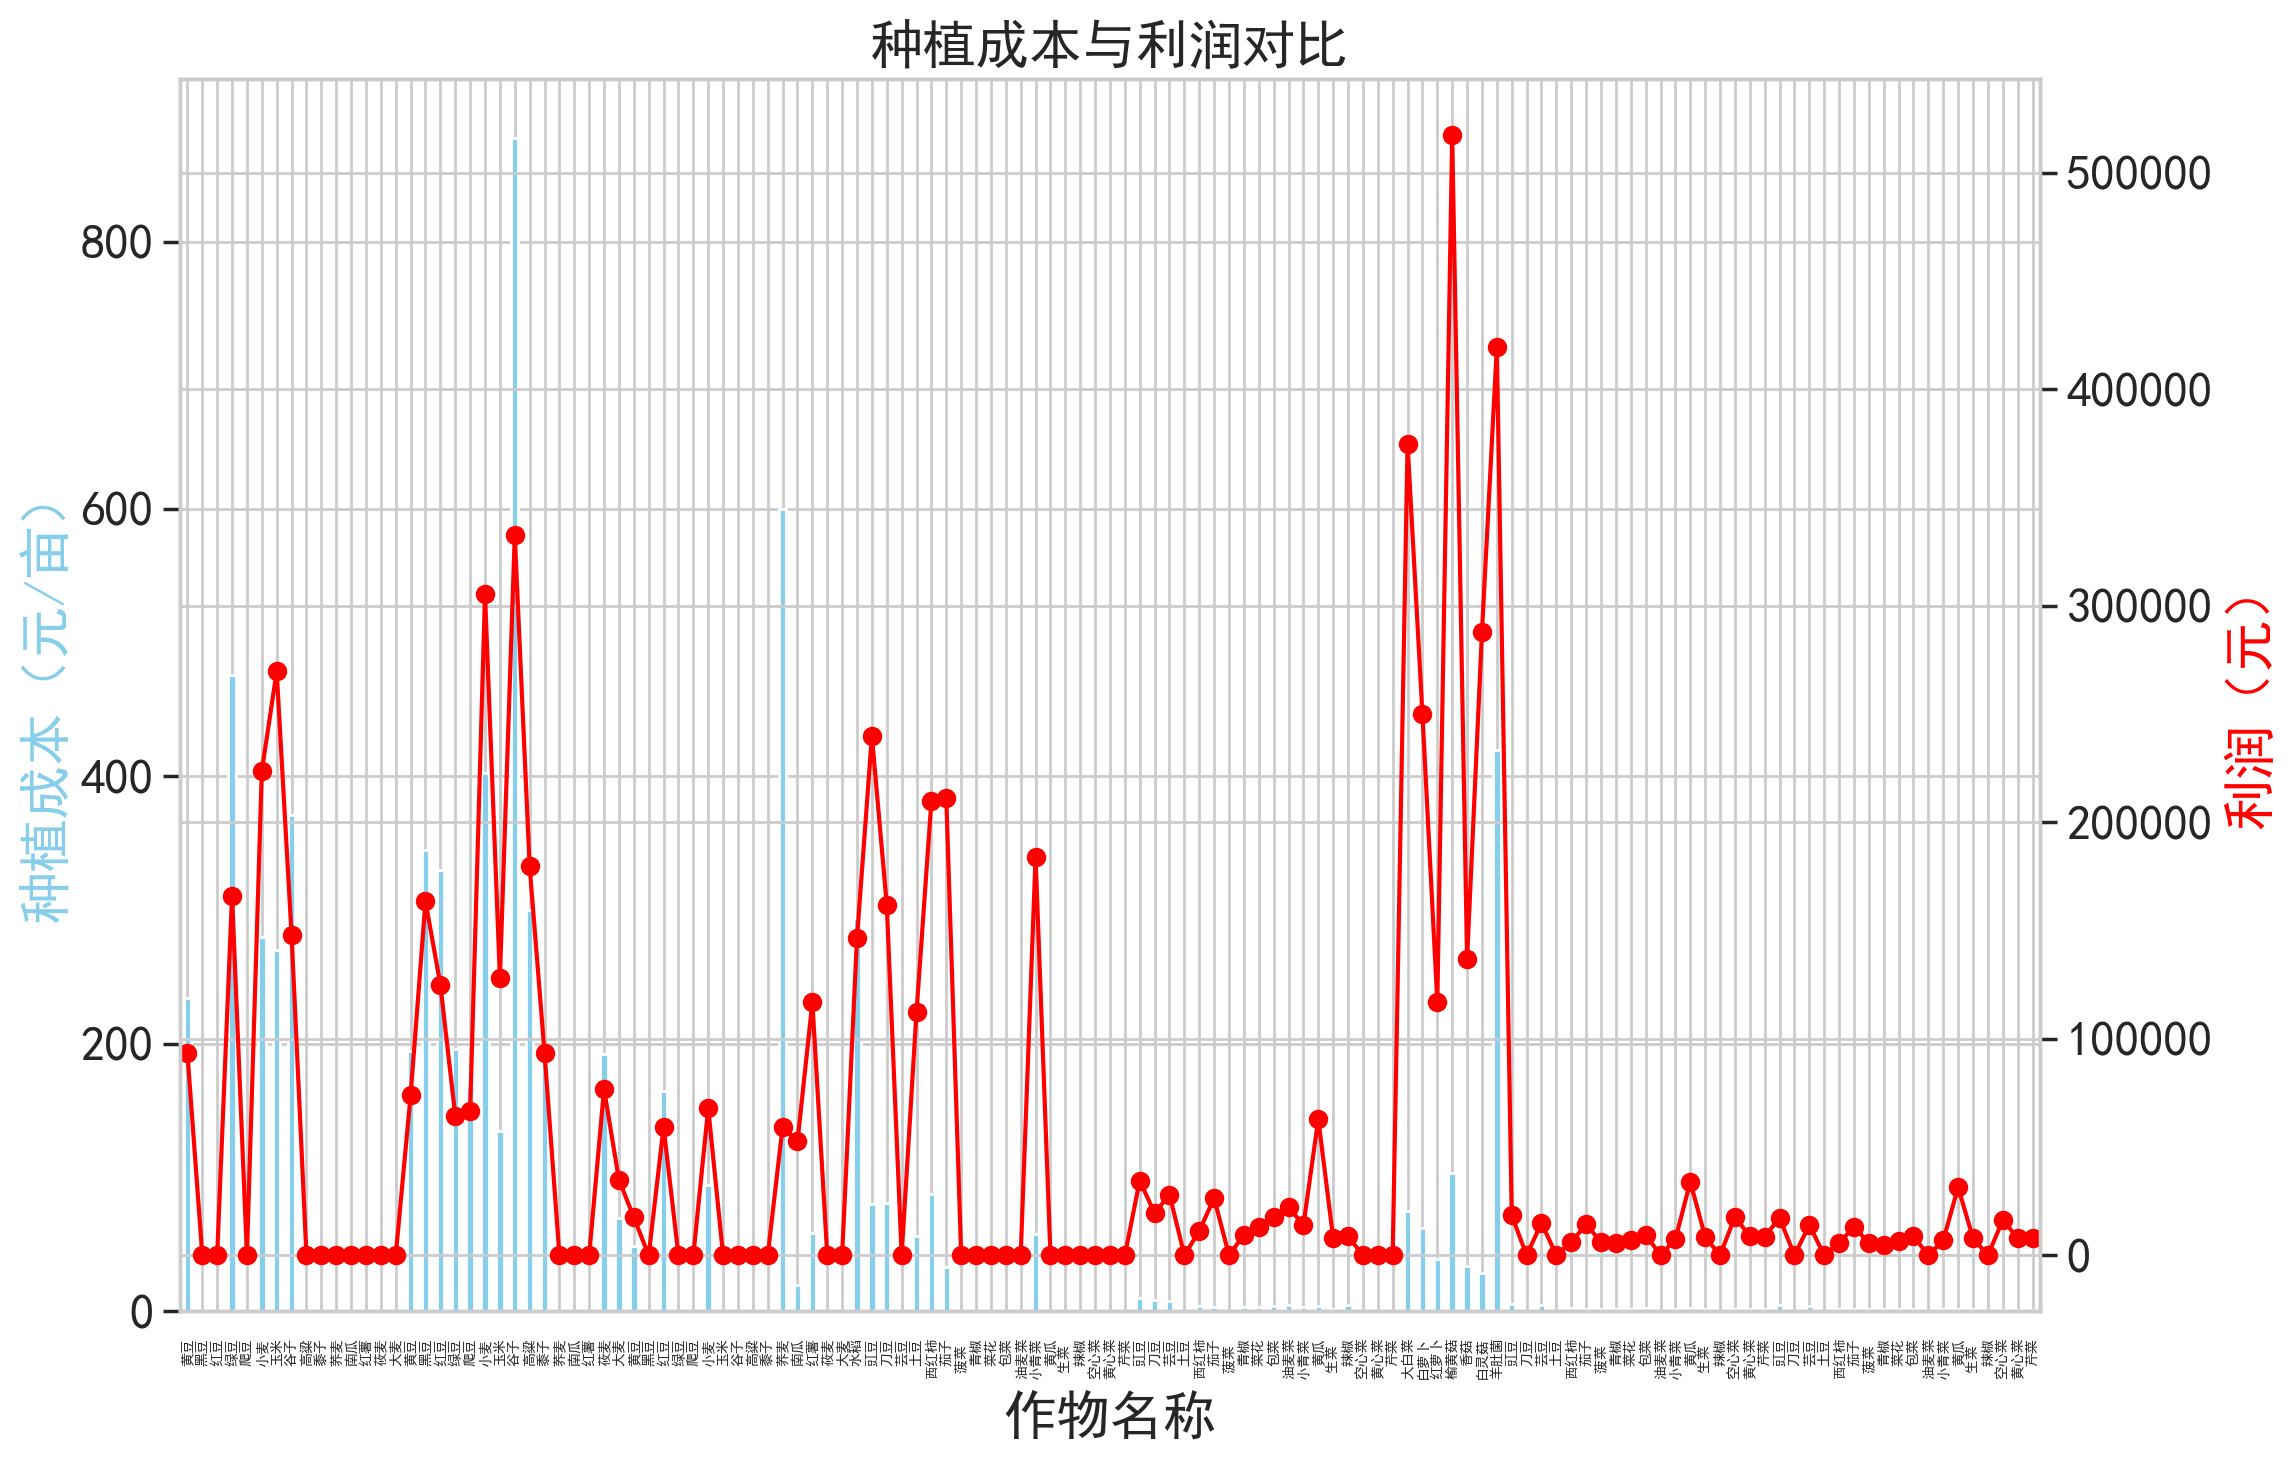

In [9]:
plt.figure(figsize=(10, 6))
ax = df.plot(kind='bar', x='作物名称', y='总成本', figsize=(12, 8), color='skyblue', legend=False)
ax.set_ylabel('种植成本（元/亩）', color='skyblue')
ax.tick_params(axis='x', labelsize=5)  # 调整 x 轴标签字体大小

ax2 = ax.twinx()
df.plot(kind='line', x='作物名称', y='总盈利', ax=ax2, color='red', marker='o', legend=False)
ax2.set_ylabel('利润（元）', color='red')
ax2.tick_params(axis='x', labelsize=0)  # 调整 x 轴标签字体大小

plt.title('种植成本与利润对比')
plt.xlabel('作物名称')

plt.show()


#### 不同作物类型的总利润与平均利润

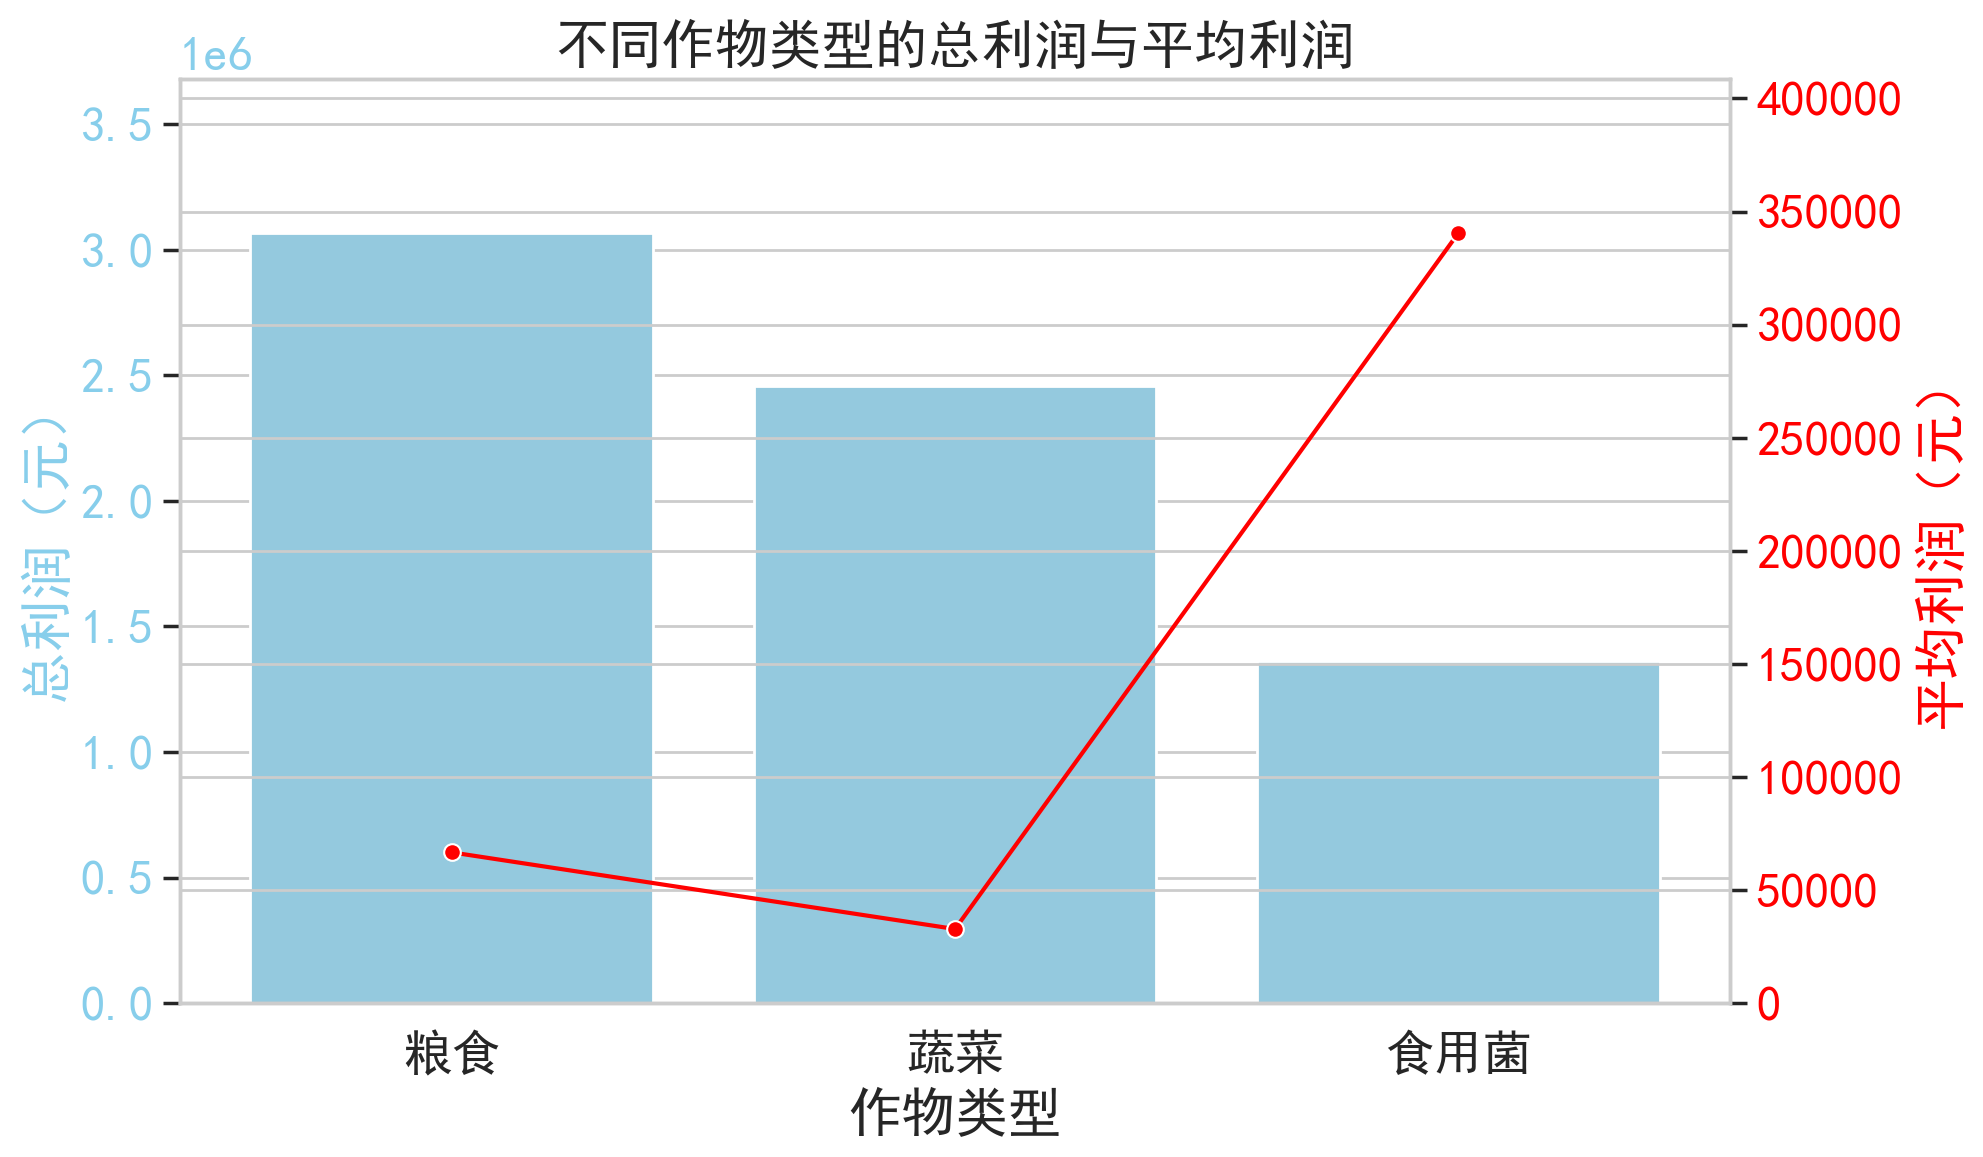

In [10]:
# 计算每种作物类型的总利润（利润合计）和平均利润
profit_by_crop_type = df.groupby('作物类型').agg(
    总盈利=('总盈利', 'sum'),
    平均利润=('总盈利', 'mean')
).reset_index()

# 创建双轴图，展示总利润和平均利润
fig, ax1 = plt.subplots(figsize=(10, 6))

# 总利润柱状图
sns.barplot(data=profit_by_crop_type, x='作物类型', y='总盈利', ax=ax1, color='skyblue')
ax1.set_ylabel('总利润（元）', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xlabel('作物类型')
ax1.set_ylim(0, profit_by_crop_type['总盈利'].max() * 1.2)

# 平均利润折线图
ax2 = ax1.twinx()
sns.lineplot(data=profit_by_crop_type, x='作物类型', y='平均利润', ax=ax2, color='red', marker='o')
ax2.set_ylabel('平均利润（元）', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, profit_by_crop_type['平均利润'].max() * 1.2)

plt.title('不同作物类型的总利润与平均利润')
plt.xticks(rotation=45)

plt.show()


### 优化模型



### 1. **决策变量**：
定义决策变量 $x_{i,j,t}$，其中：
- $i \in \{1, \dots, N\}$：表示第 $i$ 块地。
- $j \in \{1, \dots, M\}$：表示第 $j$ 种作物。
- $t \in \{1, 2\}$：表示季节，$t=1$ 为第一季，$t=2$ 为第二季。

$x_{i,j,t}$ 是一个二进制变量：
$$
x_{i,j,t} = 
\begin{cases} 
1 & \text{如果地块 } i \text{ 在第 } t \text{ 季种植作物 } j, \\
0 & \text{否则}.
\end{cases}
$$

### 2. **目标函数：利润最大化**：
最大化总利润：
$$
\text{Maximize } Z = \sum_{i=1}^{N} \sum_{j=1}^{M} \sum_{t=1}^{2} \left( p_j \cdot r_j \cdot A_i \cdot x_{i,j,t} - c_{i,j} \cdot A_i \cdot x_{i,j,t} \right)
$$
其中：
- $p_j$ 是作物 $j$ 的单价。
- $r_j$ 是作物 $j$ 的单位面积产量。
- $c_{i,j}$ 是在地块 $i$ 种植作物 $j$ 的单位成本。
- $A_i$ 是地块 $i$ 的面积。

### 3. **约束条件**：

#### 3.1 地块类型约束：
根据不同类型的地块，施加不同的种植约束。

1. **平旱地、梯田、山坡只能种一季粮食作物**：
对这些地块类型 $T_i \in \{\text{平旱地, 梯田, 山坡}\}$，只能种一季粮食：
$$
\sum_{j \in S_{\text{grain}}} x_{i,j,1} = 1 \quad \forall i \text{ such that } T_i \in \{\text{平旱地, 梯田, 山坡}\}
$$
且不能种第二季：
$$
\sum_{j=1}^{M} x_{i,j,2} = 0 \quad \forall i \text{ such that } T_i \in \{\text{平旱地, 梯田, 山坡}\}
$$

2. **水浇地只能种一季水稻或两季蔬菜**：
对于水浇地 $T_i = \text{水浇地}$，可以种一季水稻或两季蔬菜：
$$
\sum_{j \in S_{\text{rice}}} x_{i,j,1} + \sum_{j \in S_{\text{vegetable1}}} x_{i,j,1} = 1 \quad \forall i \text{ such that } T_i = \text{水浇地}
$$
且第二季只能种特定蔬菜：
$$
\sum_{j \in S_{\text{vegetable2}}} x_{i,j,2} \leq 1 \quad \forall i \text{ such that } T_i = \text{水浇地}
$$

3. **普通大棚必须种一季蔬菜和一季食用菌**：
对于普通大棚 $T_i = \text{普通大棚}$，必须种一季蔬菜和一季食用菌：
$$
\sum_{j \in S_{\text{vegetable}}} x_{i,j,1} = 1 \quad \forall i \text{ such that } T_i = \text{普通大棚}
$$
$$
\sum_{j \in S_{\text{fungi}}} x_{i,j,2} = 1 \quad \forall i \text{ such that } T_i = \text{普通大棚}
$$

4. **智慧大棚必须种两季蔬菜**：
对于智慧大棚 $T_i = \text{智慧大棚}$，每年必须种两季蔬菜：
$$
\sum_{j \in S_{\text{vegetable}}} x_{i,j,1} = 1 \quad \forall i \text{ such that } T_i = \text{智慧大棚}
$$
$$
\sum_{j \in S_{\text{vegetable}}} x_{i,j,2} = 1 \quad \forall i \text{ such that } T_i = \text{智慧大棚}
$$

#### 3.2 豆类轮作约束：
每块地至少每三年种一次豆类作物。假设豆类作物集合为 $S_{\text{bean}}$：
$$
\sum_{j \in S_{\text{bean}}} \left( x_{i,j,1} + x_{i,j,2} \right) \geq 1 \quad \forall i
$$

#### 3.3 作物不分散约束（种植面积限制）：
每种作物 $j$ 的种植总面积不能小于最小阈值 $A_{\text{min},j}$：
$$
\sum_{i=1}^{N} \sum_{t=1}^{2} A_i \cdot x_{i,j,t} \geq A_{\text{min},j} \quad \forall j
$$

#### 3.4 非负和二进制变量约束：
决策变量 $x_{i,j,t}$ 为二进制变量，表示是否种植作物：
$$
x_{i,j,t} \in \{0, 1\} \quad \forall i, \forall j, \forall t
$$

### 完整的数学模型总结：

目标函数：
$$
\text{Maximize } Z = \sum_{i=1}^{N} \sum_{j=1}^{M} \sum_{t=1}^{2} \left( p_j \cdot r_j \cdot A_i \cdot x_{i,j,t} - c_{i,j} \cdot A_i \cdot x_{i,j,t} \right)
$$

约束条件：
1. **平旱地、梯田、山坡种植限制**：
$$
\sum_{j \in S_{\text{grain}}} x_{i,j,1} = 1 \quad \forall i \text{ such that } T_i \in \{\text{平旱地, 梯田, 山坡}\}
$$
$$
\sum_{j=1}^{M} x_{i,j,2} = 0 \quad \forall i \text{ such that } T_i \in \{\text{平旱地, 梯田, 山坡}\}
$$

2. **水浇地种植限制**：
$$
\sum_{j \in S_{\text{rice}}} x_{i,j,1} + \sum_{j \in S_{\text{vegetable1}}} x_{i,j,1} = 1
$$
$$
\sum_{j \in S_{\text{vegetable2}}} x_{i,j,2} \leq 1
$$

3. **普通大棚种植限制**：
$$
\sum_{j \in S_{\text{vegetable}}} x_{i,j,1} = 1
$$
$$
\sum_{j \in S_{\text{fungi}}} x_{i,j,2} = 1
$$

4. **智慧大棚种植限制**：
$$
\sum_{j \in S_{\text{vegetable}}} x_{i,j,1} = 1
$$
$$
\sum_{j \in S_{\text{vegetable}}} x_{i,j,2} = 1
$$

5. **豆类轮作约束**：
$$
\sum_{j \in S_{\text{bean}}} \left( x_{i,j,1} + x_{i,j,2} \right) \geq 1
$$

6. **种植面积限制**：
$$
\sum_{i=1}^{N} \sum_{t=1}^{2} A_i \cdot x_{i,j,t} \geq A_{\text{min},j}
$$

7. **二进制约束**：
$$
x_{i,j,t} \in \{0, 1\} \quad \forall i, \forall j, \forall t
$$



In [11]:
for index,i in enumerate(df['地块类型'].unique()):
    df.loc[df.地块类型==i,'地块类型'] = index
df = df.sort_values(by=['地块类型','作物编号'])
for index,i in enumerate(df['作物类型'].unique()):
    df.loc[df.作物类型==i,'作物类型'] = index
for index,i in enumerate(df1['地块类型'].unique()):
    df1.loc[df1.地块类型==i,'地块类型'] = index
df['种植产量'] = df['亩产量/斤']*df['种植面积/亩']

In [12]:
for index,i in enumerate(df['作物类型'].unique()):
    df.loc[df.作物类型==i,'作物类型'] = index

ls1 = []
ls2 = []
ls3 = []
ls4 = []
ls5 = []
ls6 = []
for index,i in enumerate(zip(df.作物类型,df.种植季次,df.地块类型,df.作物名称)):
    if i[0] == 0 and i[3] != '水稻':
        ls1.append(index)
    elif i[3] == '水稻':
        ls2.append(index)
    elif (i[2] == 4 or i[2] == 5) and i[0] != 2:
        ls6.append(index)
    elif i[0] == 2:
        ls5.append(index)
    elif i[1] == '第一季':
        ls3.append(index)
    elif i[1] == '第二季':
        ls4.append(index)
bean = []
for index,i in enumerate(df['是否豆类']):
    if i =='是':
        bean.append(index)

#### 假设每个作物的销售量会在上下10%的范围内浮动，我们的策略是根据去年销量的最大上涨范围作为目标销量，秉持宁可浪费，也不无法满足百姓食品需求的原则，制作生产计划，然后在目标函数中，使用最大下降范围作为真实的销量，将其放入到目标函数中，就可以得到剩余部分造成的损失，因此就存在两个模型，一个是“超过部分滞销，直接浪费“，另一个是“以百分之五十的价格低价出售”

#### 对于未来n年，我们只需要优化最近三年的内容，只要保证每三年，每个土地都种植豆类，那么即可保证土地是营养的，并且最终的目标模型以利润最大化目标进行度量，所以未来n年，我们只需要重复的依次填写优化结果即可

In [13]:
def find_indices(lst, element):
    return [index for index, value in enumerate(lst) if value == element]
#多余的作物需要花费的成本
def function(sales_min1,sales_min2,sales_min3):
    for i in sales_min1.keys():
        total = 0
        index_ls = find_indices(land_types, i)

        total_product1 = sum([yields[j]*areas[i]*x[i][j][o]*0.2 for i in range(num_plots) for j in index_ls for o in range(2)])
        total_product2 = sum([yields[j]*areas[i]*x[i][j][o]*0.2 for i in range(num_plots) for j in index_ls for o in range(2,4)])
        total_product3 = sum([yields[j]*areas[i]*x[i][j][o]*0.2 for i in range(num_plots) for j in index_ls for o in range(4,6)])

        if total_product1 <= sales_min1[i]:
            pass
        else:
            total += (total_product1-sales_min1[i])*prices[index_ls[0]]
        if total_product2 <= sales_min2[i]:
            pass
        else:
            total += (total_product2-sales_min2[i])*prices[index_ls[0]]
            
        if total_product3 <= sales_min3[i]:
            pass
        else:
            total += (total_product3-sales_min3[i])*prices[index_ls[0]]
    return total

### 情况一：超过部分滞销，造成浪费；

In [53]:
import pulp

# 定义问题
model = pulp.LpProblem("Land_Type_Optimization", pulp.LpMaximize)

# 54 块地，每块地都有特定的类型 (0: 平旱地, 1: 梯田, 2: 山坡, 3: 水浇地, 4: 普通大棚, 5: 智慧大棚)
num_plots = 54
num_crops = len(df['作物编号'].tolist())  # 125 种属于不同地块不同季节的作物
land_types =  df['作物编号'].tolist()# 0: 平旱地, 1: 梯田, 2: 山坡, 3: 水浇地, 4: 普通大棚, 5: 智慧大棚
plot_type = df1['地块类型'].tolist()  # 每个地块对应的地块类型

# 定义变量 x[i][j][t]，表示在第i块地是否种植第j种作物，t 表示第 t 季节
x = pulp.LpVariable.dicts("x", (range(num_plots), range(num_crops), range(6)), cat="Binary")

cos = []
for o in range(num_plots):
    cos.append(df['种植成本/(元/亩)'].tolist())
    
# 定义成本、价格、产量、面积等数据 (仅示例)
sales_max = (df.groupby('作物编号').sum()['种植产量']*1.1).to_dict()
sales_min = (df.groupby('作物编号').sum()['种植产量']*0.9).to_dict()
sales = (df.groupby('作物编号').sum()['种植产量']*1).to_dict()
costs = cos # 成本矩阵

prices = (df['亩产量/斤']*df['平均销售单价']).tolist()  # 价格列表
yields = df['亩产量/斤'].tolist()  # 产量列表
areas = df1['地块面积/亩'].tolist()  # 地块面积

# 定义作物集
grain_crops = ls1  # 粮食作物集
rice_crop = ls2  # 水稻
vegetable1_crops = ls3  # 第一季蔬菜集
vegetable2_crops = ls4  # 第二季蔬菜集
fungi_crop = ls5  # 食用菌
vegetable_crops = ls6  # 智慧大棚、普通大棚蔬菜集

total_set = ls1 + ls2 + ls3 + ls4 + ls5 + ls6

ex_grain_crops = [item for item in total_set if item not in grain_crops]  # 除粮食作物集剩余元素
ex_rice_crop = [item for item in total_set if item not in rice_crop]  # 水稻..
ex_vegetable1_crops = [item for item in total_set if item not in vegetable1_crops]  # 第一季蔬菜集
ex_vegetable2_crops = [item for item in total_set if item not in vegetable2_crops]  # 第二季蔬菜集
ex_fungi_crop = [item for item in total_set if item not in fungi_crop]  # 食用菌
ex_vegetable_crops = [item for item in total_set if item not in vegetable_crops]  # 智慧大棚、普通大棚蔬菜集

bean_crops = bean #大豆索引

ex_grain_crops = [item for item in total_set if item not in grain_crops]  # 除粮食作物集剩余元素


time = 6
# 目标函数：利润最大化
model += pulp.lpSum([(prices[j] * yields[j] - costs[i][j]) * areas[i]*0.1 * x[i][j][t] 
                     for i in range(num_plots) for j in range(num_crops) for t in range(time)]) - function(sales_min,sales_min,sales_min)*2
                    #策略二 乘以0.5


# 约束条件

# 地块类型约束
for i in range(num_plots):
    if plot_type[i] in [0, 1, 2]:  # 平旱地、梯田、山坡
        for o in [0,2,4]:
            model += pulp.lpSum([x[i][j][o] for j in grain_crops]) ==8 # 每块地只能种一种作物
            model += pulp.lpSum([x[i][j][o+1] for j in range(num_crops)]) == 0  # 只能种一季，第二季不种
        
        model += pulp.lpSum([x[i][j][0]+x[i][j][2]+x[i][j][4] for j in bean_crops]) == 1 # 三年内必须有一次豆类
        
        for o in range(time):
            model += pulp.lpSum([x[i][j][o] for j in ex_grain_crops]) == 0  # 其余不能种

    elif plot_type[i] == 3:  # 水浇地
        for o in [0,2,4]:
            model += pulp.lpSum([x[i][45][o]]) + pulp.lpSum([x[i][j][o] for j in vegetable1_crops]) == 1  # 一季水稻或第一季蔬菜
            model += pulp.lpSum([x[i][j][o] for j in vegetable1_crops]) == pulp.lpSum([x[i][j][o+1] for j in vegetable2_crops])
            model += pulp.lpSum([x[i][45][o+1]]) == 0
            
            #model += pulp.lpSum([x[i][j][o+1] for j in vegetable2_crops]) + pulp.lpSum([x[i][j][o] for j in rice_crop]) == 1  # 如果第一季种菜，第二季只能种特定蔬菜
            
            model += pulp.lpSum([x[i][j][o+1] for j in ex_vegetable2_crops]) == 0  # 其余的不能种
            model += pulp.lpSum([x[i][j][o] for j in ex_vegetable1_crops]) == 0  # 其余的不能种
        
        model += pulp.lpSum([x[i][j][o] for j in bean_crops for o in range(time)]) == 1 # 三年内必须有一次豆类

    elif plot_type[i] == 4:  # 普通大棚
        for o in [0,2,4]:
            model += pulp.lpSum([x[i][j][o] for j in vegetable_crops]) == 3  # 一季蔬菜
            model += pulp.lpSum([x[i][j][o+1] for j in fungi_crop]) >= 1  # 一季食用菌
            
            model += pulp.lpSum([x[i][j][o] for j in ex_vegetable_crops]) == 0  # 其余不能种
            model += pulp.lpSum([x[i][j][o+1] for j in ex_fungi_crop]) == 0  # 其余不能种
        
        model += pulp.lpSum([x[i][j][0]+x[i][j][2]+x[i][j][4] for j in bean_crops]) == 1 # 三年内必须有一次豆类

    elif plot_type[i] == 5:  # 智慧大棚
        for o in range(time):
            model += pulp.lpSum([x[i][j][o] for j in vegetable_crops]) == 2  # 一季蔬菜
            model += pulp.lpSum([x[i][j][o] for j in ex_vegetable_crops]) == 0  # 其余不能种


        model += pulp.lpSum([x[i][j][o] for j in bean_crops for o in range(time)]) == 1 # 三年内必须有一次豆类


for j in range(num_crops):
    model += pulp.lpSum([x[i][j][o] for i in range(num_plots) if plot_type[i] == 4 for o in range(time)]) >= 2
    
#不能连续种植
for i in range(num_plots):
    for j in range(num_crops):
        model += pulp.lpSum([x[i][j][0] + x[i][j][2]]) <= 1
        model += pulp.lpSum([x[i][j][2] + x[i][j][4]]) <= 1
        model += pulp.lpSum([x[i][j][1] + x[i][j][3]]) <= 1
        model += pulp.lpSum([x[i][j][3] + x[i][j][5]]) <= 1
        


# 求解
model.solve()

# 输出结果
for i in range(num_plots):
    for j in range(num_crops):
        for t in range(6):
            if pulp.value(x[i][j][t]) == 1:
                print(f"Plot {i} should plant crop {j} in season {t}")

#制作结果图表
a = df2[['作物名称','作物类型']].drop_duplicates()
dic = {}
for i,o in zip(df2.作物名称,df2.作物类型):
    dic[i] = o               
reward = pd.DataFrame(index=df['作物名称'].unique())
reward['作物类型'] = [dic[i] for i in reward.index]

for wh in range(3):
    for t in range(6):
        result = []
        product = []
        for i in range(num_plots):
            tem = []
            product_tem = []
            n = 0
            for j in range(num_crops):
                if pulp.value(x[i][j][t]) == 1:
                    n += 1
                    tem.append(df1['地块面积/亩'].values[i])
                    product_tem.append(df1['地块面积/亩'].values[i]*df['亩产量/斤'].values[j])
                else:
                    tem.append(0)
                    product_tem.append(0)
            if max(product_tem) >0:
                product_tem = [round(i/n,1) for i in product_tem]        
            if max(tem)>0:
                tem = [round(i/n,1) for i in tem]   
            result.append(tem)
            product.append(product_tem)
        result = pd.DataFrame(result,index=df1['地块名称'].values,columns=df['作物编号'].values).T
        result = result.groupby(result.index).sum().T
        result.columns = df['作物名称'].unique()
        result.to_excel(f'问题1\\result1_1_{t%2+1}季(第{2023+t//2+1+wh*3}年).xlsx')
        
        product = pd.DataFrame(product,index=df1['地块名称'].values,columns=df['作物编号'].values).T
        product = product.groupby(product.index).sum().T
        product.columns = df['作物名称'].unique()
        reward[f'{2023+t//2+1+wh*3}年{t%2+1}季产量（斤）'] = product.sum()
reward

Plot 0 should plant crop 1 in season 2
Plot 0 should plant crop 5 in season 2
Plot 0 should plant crop 6 in season 0
Plot 0 should plant crop 6 in season 4
Plot 0 should plant crop 8 in season 2
Plot 0 should plant crop 9 in season 2
Plot 0 should plant crop 11 in season 0
Plot 0 should plant crop 11 in season 4
Plot 0 should plant crop 12 in season 0
Plot 0 should plant crop 12 in season 4
Plot 0 should plant crop 20 in season 2
Plot 0 should plant crop 21 in season 0
Plot 0 should plant crop 21 in season 4
Plot 0 should plant crop 23 in season 2
Plot 0 should plant crop 26 in season 0
Plot 0 should plant crop 26 in season 4
Plot 0 should plant crop 27 in season 0
Plot 0 should plant crop 27 in season 4
Plot 0 should plant crop 36 in season 2
Plot 0 should plant crop 38 in season 2
Plot 0 should plant crop 41 in season 0
Plot 0 should plant crop 41 in season 4
Plot 0 should plant crop 42 in season 0
Plot 0 should plant crop 42 in season 4
Plot 1 should plant crop 1 in season 2
Plot 1 

,作物类型,2024年1季产量（斤）,2024年2季产量（斤）,2025年1季产量（斤）,2025年2季产量（斤）,2026年1季产量（斤）,2026年2季产量（斤）,2027年1季产量（斤）,2027年2季产量（斤）,2028年1季产量（斤）,2028年2季产量（斤）,2029年1季产量（斤）,2029年2季产量（斤）,2030年1季产量（斤）,2030年2季产量（斤）,2031年1季产量（斤）,2031年2季产量（斤）,2032年1季产量（斤）,2032年2季产量（斤）
黄豆,粮食,0.0,128.3,0.0,0.0,0.0,88.0,0.0,128.3,0.0,0.0,0.0,88.0,0.0,128.3,0.0,0.0,0.0,88.0
黑豆,粮食,0.0,155.9,68250.0,60.0,0.0,45.0,0.0,155.9,68250.0,60.0,0.0,45.0,0.0,155.9,68250.0,60.0,0.0,45.0
红豆,粮食,0.0,92.0,0.0,45.6,0.0,84.0,0.0,92.0,0.0,45.6,0.0,84.0,0.0,92.0,0.0,45.6,0.0,84.0
绿豆,粮食,0.0,99.9,0.0,57.0,0.0,0.0,0.0,99.9,0.0,57.0,0.0,0.0,0.0,99.9,0.0,57.0,0.0,0.0
爬豆,粮食,0.0,101.7,0.0,110.6,0.0,37.5,0.0,101.7,0.0,110.6,0.0,37.5,0.0,101.7,0.0,110.6,0.0,37.5
小麦,粮食,78.3,132.0,213036.0,65.1,0.0,0.0,78.3,132.0,213036.0,65.1,0.0,0.0,78.3,132.0,213036.0,65.1,0.0,0.0
玉米,粮食,266337.5,71.2,122939.0,0.0,266174.8,0.0,266337.5,71.2,122939.0,0.0,266174.8,0.0,266337.5,71.2,122939.0,0.0,266174.8,0.0
谷子,粮食,0.0,70.6,85.0,34.3,0.0,0.0,0.0,70.6,85.0,34.3,0.0,0.0,0.0,70.6,85.0,34.3,0.0,0.0
高粱,粮食,99.7,0.0,245783.1,0.0,0.0,0.0,99.7,0.0,245783.1,0.0,0.0,0.0,99.7,0.0,245783.1,0.0,0.0,0.0
黍子,粮食,81.2,0.0,71758.7,0.0,0.0,0.0,81.2,0.0,71758.7,0.0,0.0,0.0,81.2,0.0,71758.7,0.0,0.0,0.0


In [54]:
sale = sales.values() #销量
df['平均成本'] = df['亩产量/斤']/df['种植成本/(元/亩)'] #平均成本
cost = df.sort_values(by='作物编号').drop_duplicates(subset='作物名称')['平均成本'].values
price = df['平均销售单价'].values

result = pd.DataFrame()
result.index=reward.index
for c in reward.columns[1:]:
    lss = []
    for i,o,n,m in zip(reward[c].values,sale,cost,price):
        if i > o:
            lss.append(o*(m-n))
        else:
            lss.append(i*(m-n))
    result[c+'盈利'] = lss
result['作物类型'] = reward['作物类型']
result.groupby('作物类型').sum().to_excel('问题1\\情况一不同年份总的盈利情况.xlsx')
result.groupby('作物类型').sum()

,2024年1季产量（斤）盈利,2024年2季产量（斤）盈利,2025年1季产量（斤）盈利,2025年2季产量（斤）盈利,2026年1季产量（斤）盈利,2026年2季产量（斤）盈利,2027年1季产量（斤）盈利,2027年2季产量（斤）盈利,2028年1季产量（斤）盈利,2028年2季产量（斤）盈利,2029年1季产量（斤）盈利,2029年2季产量（斤）盈利,2030年1季产量（斤）盈利,2030年2季产量（斤）盈利,2031年1季产量（斤）盈利,2031年2季产量（斤）盈利,2032年1季产量（斤）盈利,2032年2季产量（斤）盈利
作物类型,,,,,,,,,,,,,,,,,,
粮食,171743.933399,5050.133826,771089.048889,1582.677698,170035.200000,1490.421429,171743.933399,5050.133826,771089.048889,1582.677698,170035.200000,1490.421429,171743.933399,5050.133826,771089.048889,1582.677698,170035.200000,1490.421429
蔬菜,115797.878231,663681.979058,456766.357878,-374124.363098,138276.705353,679865.000000,115797.878231,663681.979058,456766.357878,-374124.363098,138276.705353,679865.000000,115797.878231,663681.979058,456766.357878,-374124.363098,138276.705353,679865.000000
食用菌,0.000000,191550.000000,0.000000,167580.000000,0.000000,191550.000000,0.000000,191550.000000,0.000000,167580.000000,0.000000,191550.000000,0.000000,191550.000000,0.000000,167580.000000,0.000000,191550.000000


### 情况二：超过部分按 2023 年销售价格的 50%降价出售。

In [62]:
import pulp

# 定义问题
model = pulp.LpProblem("Land_Type_Optimization", pulp.LpMaximize)

# 54 块地，每块地都有特定的类型 (0: 平旱地, 1: 梯田, 2: 山坡, 3: 水浇地, 4: 普通大棚, 5: 智慧大棚)
num_plots = 54
num_crops = len(df['作物编号'].tolist())  # 125 种属于不同地块不同季节的作物
land_types =  df['作物编号'].tolist()# 0: 平旱地, 1: 梯田, 2: 山坡, 3: 水浇地, 4: 普通大棚, 5: 智慧大棚
plot_type = df1['地块类型'].tolist()  # 每个地块对应的地块类型

# 定义变量 x[i][j][t]，表示在第i块地是否种植第j种作物，t 表示第 t 季节
x = pulp.LpVariable.dicts("x", (range(num_plots), range(num_crops), range(6)), cat="Binary")

cos = []
for o in range(num_plots):
    cos.append(df['种植成本/(元/亩)'].tolist())
    
# 定义成本、价格、产量、面积等数据 (仅示例)
sales_max = (df.groupby('作物编号').sum()['种植产量']*1.1).to_dict()
sales_min = (df.groupby('作物编号').sum()['种植产量']*0.9).to_dict()
sales = (df.groupby('作物编号').sum()['种植产量']*1).to_dict()
costs = cos # 成本矩阵

prices = (df['亩产量/斤']*df['平均销售单价']).tolist()  # 价格列表
yields = df['亩产量/斤'].tolist()  # 产量列表
areas = df1['地块面积/亩'].tolist()  # 地块面积

# 定义作物集
grain_crops = ls1  # 粮食作物集
rice_crop = ls2  # 水稻
vegetable1_crops = ls3  # 第一季蔬菜集
vegetable2_crops = ls4  # 第二季蔬菜集
fungi_crop = ls5  # 食用菌
vegetable_crops = ls6  # 智慧大棚、普通大棚蔬菜集

total_set = ls1 + ls2 + ls3 + ls4 + ls5 + ls6

ex_grain_crops = [item for item in total_set if item not in grain_crops]  # 除粮食作物集剩余元素
ex_rice_crop = [item for item in total_set if item not in rice_crop]  # 水稻..
ex_vegetable1_crops = [item for item in total_set if item not in vegetable1_crops]  # 第一季蔬菜集
ex_vegetable2_crops = [item for item in total_set if item not in vegetable2_crops]  # 第二季蔬菜集
ex_fungi_crop = [item for item in total_set if item not in fungi_crop]  # 食用菌
ex_vegetable_crops = [item for item in total_set if item not in vegetable_crops]  # 智慧大棚、普通大棚蔬菜集

bean_crops = bean #大豆索引

ex_grain_crops = [item for item in total_set if item not in grain_crops]  # 除粮食作物集剩余元素


time = 6
# 目标函数：利润最大化
model += pulp.lpSum([(prices[j] * yields[j] - costs[i][j]) * areas[i]*0.1 * x[i][j][t] 
                     for i in range(num_plots) for j in range(num_crops) for t in range(time)]) - function(sales_min,sales_min,sales_min)*0.5 
                    #策略二 乘以0.5


# 约束条件

# 地块类型约束
for i in range(num_plots):
    if plot_type[i] in [0, 1, 2]:  # 平旱地、梯田、山坡
        for o in [0,2,4]:
            model += pulp.lpSum([x[i][j][o] for j in grain_crops]) ==9 # 每块地只能种一种作物
            model += pulp.lpSum([x[i][j][o+1] for j in range(num_crops)]) == 0  # 只能种一季，第二季不种
        
        model += pulp.lpSum([x[i][j][0]+x[i][j][2]+x[i][j][4] for j in bean_crops]) == 1 # 三年内必须有一次豆类
        
        for o in range(time):
            model += pulp.lpSum([x[i][j][o] for j in ex_grain_crops]) == 0  # 其余不能种

    elif plot_type[i] == 3:  # 水浇地
        for o in [0,2,4]:
            model += pulp.lpSum([x[i][45][o]]) + pulp.lpSum([x[i][j][o] for j in vegetable1_crops]) == 1  # 一季水稻或第一季蔬菜
            model += pulp.lpSum([x[i][j][o] for j in vegetable1_crops]) == pulp.lpSum([x[i][j][o+1] for j in vegetable2_crops])
            model += pulp.lpSum([x[i][45][o+1]]) == 0
            
            #model += pulp.lpSum([x[i][j][o+1] for j in vegetable2_crops]) + pulp.lpSum([x[i][j][o] for j in rice_crop]) == 1  # 如果第一季种菜，第二季只能种特定蔬菜
            
            model += pulp.lpSum([x[i][j][o+1] for j in ex_vegetable2_crops]) == 0  # 其余的不能种
            model += pulp.lpSum([x[i][j][o] for j in ex_vegetable1_crops]) == 0  # 其余的不能种
        
        model += pulp.lpSum([x[i][j][o] for j in bean_crops for o in range(time)]) == 1 # 三年内必须有一次豆类

    elif plot_type[i] == 4:  # 普通大棚
        for o in [0,2,4]:
            model += pulp.lpSum([x[i][j][o] for j in vegetable_crops]) == 3  # 一季蔬菜
            model += pulp.lpSum([x[i][j][o+1] for j in fungi_crop]) >= 1  # 一季食用菌
            
            model += pulp.lpSum([x[i][j][o] for j in ex_vegetable_crops]) == 0  # 其余不能种
            model += pulp.lpSum([x[i][j][o+1] for j in ex_fungi_crop]) == 0  # 其余不能种
        
        model += pulp.lpSum([x[i][j][0]+x[i][j][2]+x[i][j][4] for j in bean_crops]) == 1 # 三年内必须有一次豆类

    elif plot_type[i] == 5:  # 智慧大棚
        for o in range(time):
            model += pulp.lpSum([x[i][j][o] for j in vegetable_crops]) == 2  # 一季蔬菜
            model += pulp.lpSum([x[i][j][o] for j in ex_vegetable_crops]) == 0  # 其余不能种


        model += pulp.lpSum([x[i][j][o] for j in bean_crops for o in range(time)]) == 1 # 三年内必须有一次豆类


for j in range(num_crops):
    model += pulp.lpSum([x[i][j][o] for i in range(num_plots) if plot_type[i] == 4 for o in range(time)]) >= 2
    
#不能连续种植
for i in range(num_plots):
    for j in range(num_crops):
        model += pulp.lpSum([x[i][j][0] + x[i][j][2]]) <= 1
        model += pulp.lpSum([x[i][j][2] + x[i][j][4]]) <= 1
        model += pulp.lpSum([x[i][j][1] + x[i][j][3]]) <= 1
        model += pulp.lpSum([x[i][j][3] + x[i][j][5]]) <= 1
        


# 求解
model.solve()

# 输出结果
for i in range(num_plots):
    for j in range(num_crops):
        for t in range(6):
            if pulp.value(x[i][j][t]) == 1:
                print(f"Plot {i} should plant crop {j} in season {t}")

#制作结果图表
a = df2[['作物名称','作物类型']].drop_duplicates()
dic = {}
for i,o in zip(df2.作物名称,df2.作物类型):
    dic[i] = o               
reward = pd.DataFrame(index=df['作物名称'].unique())
reward['作物类型'] = [dic[i] for i in reward.index]

for wh in range(3):
    for t in range(6):
        result = []
        product = []
        for i in range(num_plots):
            tem = []
            product_tem = []
            n = 0
            for j in range(num_crops):
                if pulp.value(x[i][j][t]) == 1:
                    n += 1
                    tem.append(df1['地块面积/亩'].values[i])
                    product_tem.append(df1['地块面积/亩'].values[i]*df['亩产量/斤'].values[j])
                else:
                    tem.append(0)
                    product_tem.append(0)
            if max(product_tem) >0:
                product_tem = [round(i/n,1) for i in product_tem]        
            if max(tem)>0:
                tem = [round(i/n,1) for i in tem]   
            result.append(tem)
            product.append(product_tem)
        result = pd.DataFrame(result,index=df1['地块名称'].values,columns=df['作物编号'].values).T
        result = result.groupby(result.index).sum().T
        result.columns = df['作物名称'].unique()
        result.to_excel(f'问题1\\result2_1_{t%2+1}季(第{2023+t//2+1+wh*3}年).xlsx')
        
        product = pd.DataFrame(product,index=df1['地块名称'].values,columns=df['作物编号'].values).T
        product = product.groupby(product.index).sum().T
        product.columns = df['作物名称'].unique()
        reward[f'{2023+t//2+1+wh*3}年{t%2+1}季产量（斤）'] = product.sum()
reward

Plot 0 should plant crop 1 in season 2
Plot 0 should plant crop 5 in season 2
Plot 0 should plant crop 6 in season 0
Plot 0 should plant crop 6 in season 4
Plot 0 should plant crop 8 in season 2
Plot 0 should plant crop 9 in season 2
Plot 0 should plant crop 11 in season 0
Plot 0 should plant crop 11 in season 4
Plot 0 should plant crop 12 in season 0
Plot 0 should plant crop 12 in season 4
Plot 0 should plant crop 20 in season 2
Plot 0 should plant crop 21 in season 0
Plot 0 should plant crop 21 in season 4
Plot 0 should plant crop 23 in season 2
Plot 0 should plant crop 24 in season 2
Plot 0 should plant crop 26 in season 0
Plot 0 should plant crop 26 in season 4
Plot 0 should plant crop 27 in season 0
Plot 0 should plant crop 27 in season 4
Plot 0 should plant crop 35 in season 2
Plot 0 should plant crop 36 in season 0
Plot 0 should plant crop 36 in season 4
Plot 0 should plant crop 38 in season 2
Plot 0 should plant crop 41 in season 0
Plot 0 should plant crop 41 in season 4
Plot 0

,作物类型,2024年1季产量（斤）,2024年2季产量（斤）,2025年1季产量（斤）,2025年2季产量（斤）,2026年1季产量（斤）,2026年2季产量（斤）,2027年1季产量（斤）,2027年2季产量（斤）,2028年1季产量（斤）,2028年2季产量（斤）,2029年1季产量（斤）,2029年2季产量（斤）,2030年1季产量（斤）,2030年2季产量（斤）,2031年1季产量（斤）,2031年2季产量（斤）,2032年1季产量（斤）,2032年2季产量（斤）
黄豆,粮食,0.0,64.3,0.0,249.0,0.0,0.0,0.0,64.3,0.0,249.0,0.0,0.0,0.0,64.3,0.0,249.0,0.0,0.0
黑豆,粮食,0.0,95.4,60666.6,100.6,0.0,0.0,0.0,95.4,60666.6,100.6,0.0,0.0,0.0,95.4,60666.6,100.6,0.0,0.0
红豆,粮食,0.0,106.7,0.0,120.3,0.0,0.0,0.0,106.7,0.0,120.3,0.0,0.0,0.0,106.7,0.0,120.3,0.0,0.0
绿豆,粮食,0.0,122.8,0.0,31.5,0.0,0.0,0.0,122.8,0.0,31.5,0.0,0.0,0.0,122.8,0.0,31.5,0.0,0.0
爬豆,粮食,0.0,93.1,0.0,112.2,0.0,0.0,0.0,93.1,0.0,112.2,0.0,0.0,0.0,93.1,0.0,112.2,0.0,0.0
小麦,粮食,48.0,86.6,276741.1,0.0,0.0,0.0,48.0,86.6,276741.1,0.0,0.0,0.0,48.0,86.6,276741.1,0.0,0.0,0.0
玉米,粮食,345800.1,147.0,81.5,60.0,345800.1,0.0,345800.1,147.0,81.5,60.0,345800.1,0.0,345800.1,147.0,81.5,60.0,345800.1,0.0
谷子,粮食,0.0,43.3,78.1,40.0,0.0,0.0,0.0,43.3,78.1,40.0,0.0,0.0,0.0,43.3,78.1,40.0,0.0,0.0
高粱,粮食,0.0,58.4,218502.8,0.0,0.0,0.0,0.0,58.4,218502.8,0.0,0.0,0.0,0.0,58.4,218502.8,0.0,0.0,0.0
黍子,粮食,33.3,22.5,124430.9,35.6,0.0,0.0,33.3,22.5,124430.9,35.6,0.0,0.0,33.3,22.5,124430.9,35.6,0.0,0.0


In [63]:
# sale = sales.values() #销量
df['平均成本'] = df['亩产量/斤']/df['种植成本/(元/亩)'] #平均成本
cost = df.sort_values(by='作物编号').drop_duplicates(subset='作物名称')['平均成本'].values
price = df['平均销售单价'].values

result = pd.DataFrame()
result.index=reward.index
for c in reward.columns[1:]:
    ls = []
    for i,o,n,m in zip(reward[c].values,sale,cost,price):
        if i > o:
            ls.append(o*(m-n)+(i-o)*(m-n)*0.5)
        else:
            ls.append(i*(m-n))
    result[c+'盈利'] = ls
result['作物类型'] = reward['作物类型']
result.groupby('作物类型').sum().to_excel('问题1\\情况二不同年份总的盈利情况.xlsx')
result.groupby('作物类型').sum()

,2024年1季产量（斤）盈利,2024年2季产量（斤）盈利,2025年1季产量（斤）盈利,2025年2季产量（斤）盈利,2026年1季产量（斤）盈利,2026年2季产量（斤）盈利,2027年1季产量（斤）盈利,2027年2季产量（斤）盈利,2028年1季产量（斤）盈利,2028年2季产量（斤）盈利,2029年1季产量（斤）盈利,2029年2季产量（斤）盈利,2030年1季产量（斤）盈利,2030年2季产量（斤）盈利,2031年1季产量（斤）盈利,2031年2季产量（斤）盈利,2032年1季产量（斤）盈利,2032年2季产量（斤）盈利
作物类型,,,,,,,,,,,,,,,,,,
粮食,479169.427843,4.039520e+03,1.626749e+06,4.433710e+03,476214.940000,0.000000e+00,479169.427843,4.039520e+03,1.626749e+06,4.433710e+03,476214.940000,0.000000e+00,479169.427843,4.039520e+03,1.626749e+06,4.433710e+03,476214.940000,0.000000e+00
蔬菜,983135.276800,1.517824e+06,1.330501e+06,-1.103301e+06,975054.921563,1.514457e+06,983135.276800,1.517824e+06,1.330501e+06,-1.103301e+06,975054.921563,1.514457e+06,983135.276800,1.517824e+06,1.330501e+06,-1.103301e+06,975054.921563,1.514457e+06
食用菌,0.000000,2.141396e+05,0.000000e+00,2.077134e+05,0.000000,2.527396e+05,0.000000,2.141396e+05,0.000000e+00,2.077134e+05,0.000000,2.527396e+05,0.000000,2.141396e+05,0.000000e+00,2.077134e+05,0.000000,2.527396e+05
